In [1]:
import pandas as pd
#Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys

/Users/atefeh/miniconda3/envs/tf2/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
pd.set_option('display.max_rows', None)
data  = pd.read_csv('marketing_campaign.csv',sep="\t")
data.head(3)
data = data.dropna()
data.head(3)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0


In [3]:
# Convert Dt_Customer to datetime, specifying dayfirst=True
df =data
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], dayfirst=True)

# Use the maximum date in the dataset as 'Date_Collected' (the latest data collection date)
df['Date_Collected'] = df['Dt_Customer'].max()

# Calculate the number of days each customer has been enrolled (difference between collection date and enrollment date)
df['Time_Enrolled_Days'] = (df['Date_Collected'] - df['Dt_Customer']).dt.days


In [4]:
#Feature Engineering


#Age of customer today 
data["Age"] = 2021 - data["Year_Birth"]

#Total Expenses on various items
data["Expenses"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

# Marital_Status
data["Marital_Status"] = data["Marital_Status"].replace({"Married":"In relationship", "Together":"In relationship", "Absurd":"Single", "Widow":"Single", "YOLO":"Single", "Divorced":"Single", "Single":"Single","Alone":"Single"})

#Feature indicating total children living in the household
data["Children"]=data["Kidhome"]+data["Teenhome"]

#Feature for total members in the householde
data["Family_Size"] = data["Marital_Status"].replace({"Single": 1, "In relationship": 2}) + data["Children"]



#Feature pertaining parenthood
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

#Segmenting education levels in three groups
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#For clarity
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Dropping some of the redundant features
to_drop = ["Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth"]
data = data.drop(to_drop, axis=1)

/var/folders/76/1yzscp4d71l1rljcgf5sbbfm0000gn/T/ipykernel_37004/1759938208.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["Family_Size"] = data["Marital_Status"].replace({"Single": 1, "In relationship": 2}) + data["Children"]


In [5]:

#Dropping the outliers by setting a cap on Age and income. 
data = data[(data["Age"]<90)]
data = data[(data["Income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(data))

The total number of data-points after removing the outliers are: 2212


In [6]:
#Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Marital_Status']


In [7]:
#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)
    
print("All features are now numerical")

All features are now numerical


In [8]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Creating a copy of the data
ds = data.copy()

# List of columns to drop (features related to deals accepted and promotions)
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)

# Drop any DateTime columns from the dataset
date_cols = ds.select_dtypes(include=['datetime64']).columns
ds = ds.drop(date_cols, axis=1)

# Scaling
scaler = StandardScaler()
scaled_ds = pd.DataFrame(scaler.fit_transform(ds), columns=ds.columns)
print("All features are now scaled")


All features are now scaled


In [9]:
#Metriklerimizi olusturalim


data['Frequency'] = data['NumWebPurchases'] + data['NumCatalogPurchases'] + data['NumStorePurchases']
RFM = data.loc[:, ['ID', 'Recency', 'Frequency', 'Expenses']]
RFM['Recency'].astype('int64')
RFM['Frequency'] = RFM['Frequency'].astype('int64')
RFM['Monatery'] = RFM['Expenses'].astype('int64')
# Step 2: Create R, F, M Scores by binning into quantiles (1 to 5 scale)
RFM['R_Score'] = pd.qcut(RFM['Recency'], 5, labels=[5, 4, 3, 2, 1])  # Lower recency is better
RFM['F_Score'] = pd.qcut(RFM['Frequency'], 5, labels=[1, 2, 3, 4, 5])  # Higher frequency is better
RFM['M_Score'] = pd.qcut(RFM['Expenses'], 5, labels=[1, 2, 3, 4, 5])  # Higher monetary is better

# Step 3: Combine R, F, M Scores to calculate the RFM Score
RFM['RFM_Score'] = RFM['R_Score'].astype(str) + RFM['F_Score'].astype(str) + RFM['M_Score'].astype(str)
RFM


# Step 1: Define a function to categorize each customer
def categorize_rfm(row):
    r, f, m = row['R_Score'], row['F_Score'], row['M_Score']
    
    if r == 5 and f == 5 and m == 5:
        return 'Best Customers'
    elif r >= 4 and f >= 3 and m >= 3:
        return 'Loyal Customers'
    elif r >= 3 and f >= 2 and m >= 2:
        return 'Potential Loyalist'
    elif r >= 4 and f <= 2:
        return 'At Risk'
    elif r <= 2 and f <= 2:
        return 'Lost Customers'
    else:
        return 'Other'

# Step 2: Apply the function to categorize each customer
RFM['Customer_Segment'] = RFM.apply(categorize_rfm, axis=1)
RFM


data = data.merge(RFM[['ID', 'RFM_Score','Customer_Segment']], on='ID', how='left')
data.head(3)

,ID,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,...,Date_Collected,Time_Enrolled_Days,Age,Expenses,Children,Family_Size,Is_Parent,Frequency,RFM_Score,Customer_Segment
0,5524,0,1,58138.0,0,0,58,635,88,546,...,2014-06-29,663,64,1617,0,1,0,22,355,Potential Loyalist
1,2174,0,1,46344.0,1,1,38,11,1,6,...,2014-06-29,113,67,27,2,3,1,4,411,At Risk
2,4141,0,0,71613.0,0,0,26,426,49,127,...,2014-06-29,312,56,776,0,2,0,20,444,Loyal Customers


# PCA

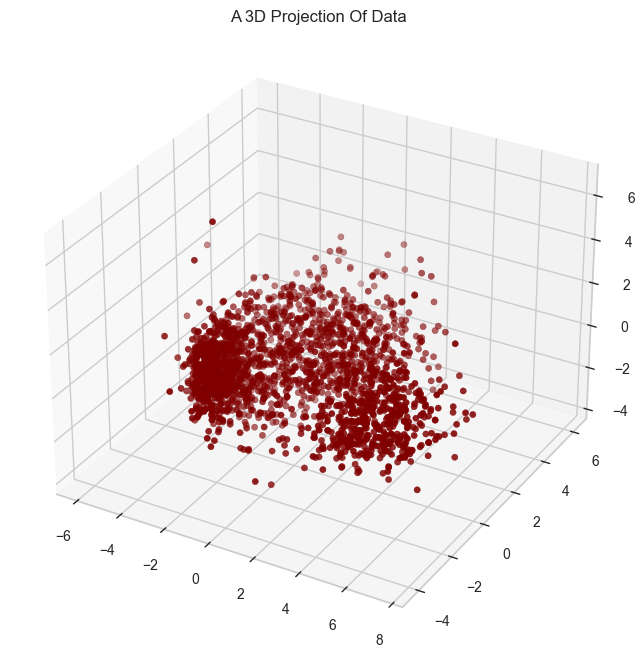

In [18]:
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data")
plt.show()

# CLUSTERING

Elbow Method to determine the number of clusters to be formed:


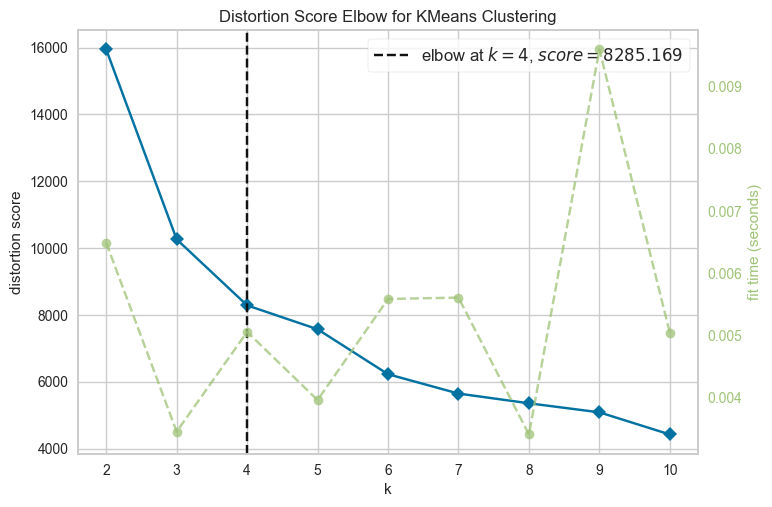

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [26]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

In [27]:
#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
data["Clusters"]= yhat_AC


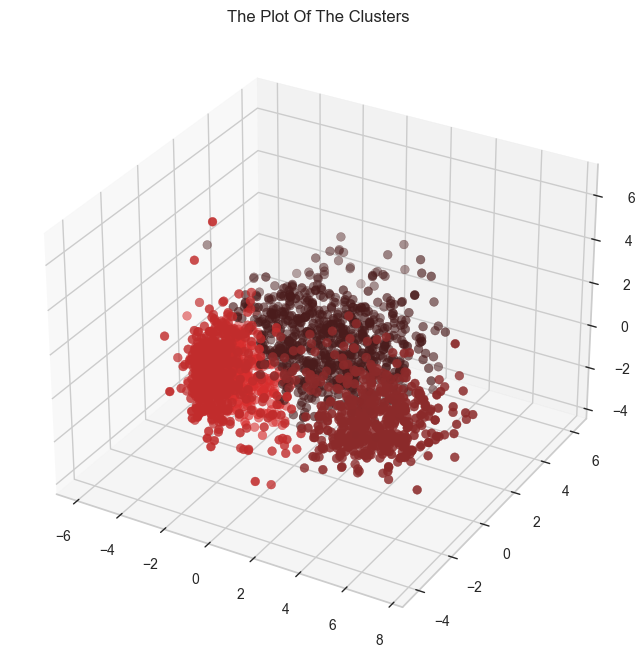

In [21]:
#Plotting the clusters
cmap = colors.ListedColormap(["#4A1C1C", "#6D2C2C", "#8B2A2A", "#A73D3D", "#C12C2C", "#D82E2E"])
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

/var/folders/76/1yzscp4d71l1rljcgf5sbbfm0000gn/T/ipykernel_37004/1859745431.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.countplot(x=data["Clusters"], palette= pal)


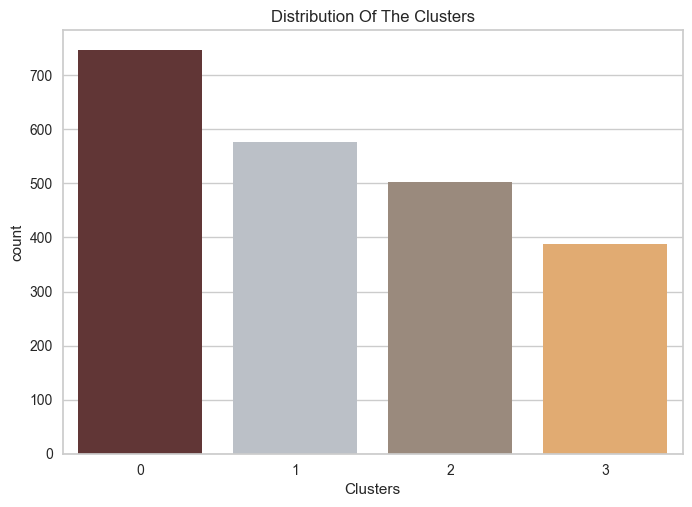

In [28]:
#Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=data["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

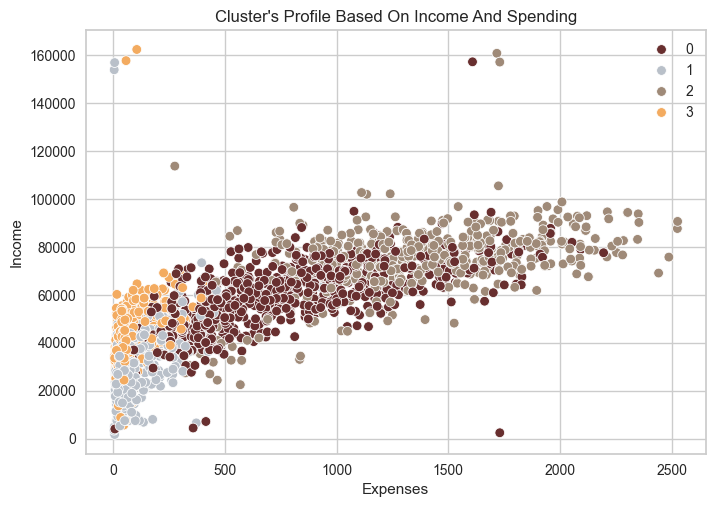

In [29]:
pl = sns.scatterplot(data = data,x=data["Expenses"], y=data["Income"],hue=data["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

In [31]:
import pandas as pd

# Sample data
# data = pd.read_csv("your_data.csv")  # Assuming your data is in a CSV file

# Group by 'Clusters' and calculate the sum of 'NumDealsPurchases'
cluster_sums = data.groupby("Clusters")["Expenses"].sum()

# Calculate the total number of deals purchased
total_deals = data["Expenses"].sum()

# Calculate percentage for each cluster
percentage_deals = (cluster_sums / total_deals) * 100

# Convert to DataFrame for better readability
percentage_deals_df = percentage_deals.reset_index(name='Percentage')

# Display the results
print(round(percentage_deals_df,2))

   Clusters  Percentage
0         0       42.72
1         1        3.96
2         2       50.70
3         3        2.62


/Users/atefeh/miniconda3/envs/tf2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 8.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/atefeh/miniconda3/envs/tf2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 66.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/atefeh/miniconda3/envs/tf2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 58.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/var/folders/76/1yzscp4d71l1rljcgf5sbbfm0000gn/T/ipykernel_37004/2995037347.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  s

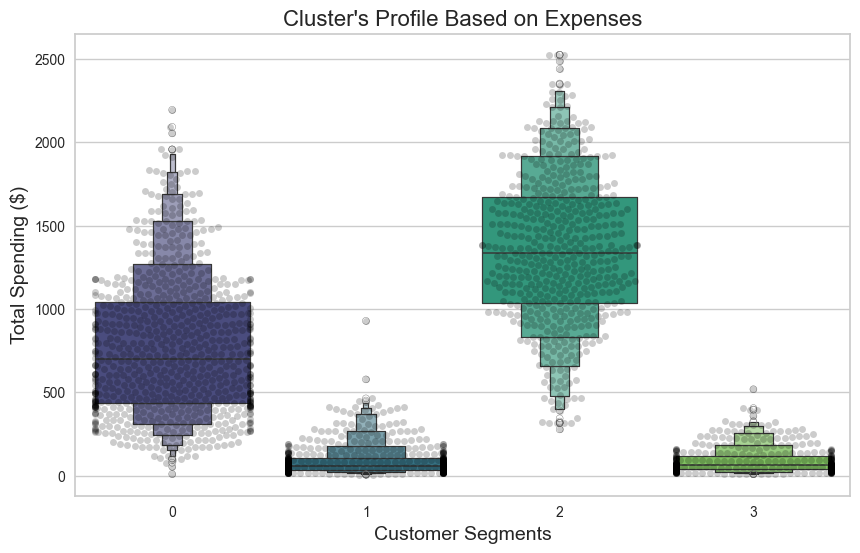

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming data is already defined and contains the necessary columns

# Set the figure size
plt.figure(figsize=(10, 6))

# Swarmplot with light-colored points for transparency
sns.swarmplot(x=data["Clusters"], y=data["Expenses"], alpha=0.2, color='black')

# Boxenplot with the custom palette
sns.boxenplot(x=data["Clusters"], y=data["Expenses"], palette="viridis")

# Set titles and labels
plt.title("Cluster's Profile Based on Expenses", fontsize=16)
plt.xlabel('Customer Segments', fontsize=14)  
plt.ylabel('Total Spending ($)', fontsize=14)

# Show the plot
plt.show()  # Display the plot


/var/folders/76/1yzscp4d71l1rljcgf5sbbfm0000gn/T/ipykernel_37004/2023298088.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl=sns.boxenplot(y=data["NumDealsPurchases"],x=data["Clusters"], palette="viridis")


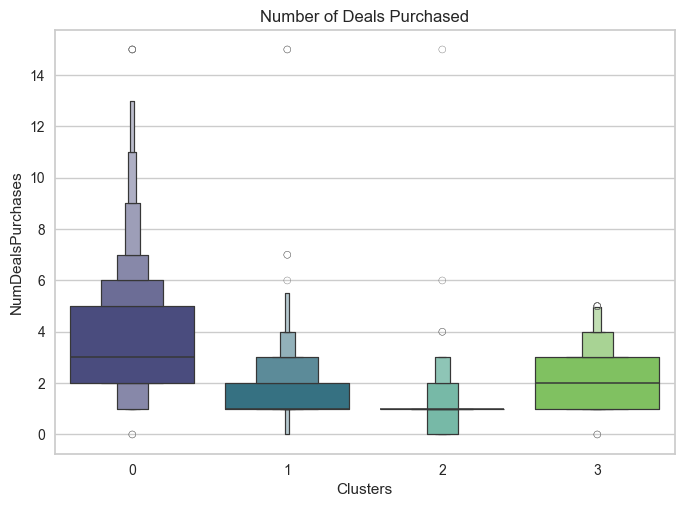

In [33]:
#Plotting the number of deals purchased
plt.figure()
pl=sns.boxenplot(y=data["NumDealsPurchases"],x=data["Clusters"], palette="viridis")
pl.set_title("Number of Deals Purchased")
plt.show()

In [34]:
import pandas as pd

# Sample data
# data = pd.read_csv("your_data.csv")  # Assuming your data is in a CSV file

# Group by 'Clusters' and calculate the sum of 'NumDealsPurchases'
cluster_sums = data.groupby("Clusters")["NumDealsPurchases"].sum()

# Calculate the total number of deals purchased
total_deals = data["NumDealsPurchases"].sum()

# Calculate percentage for each cluster
percentage_deals = (cluster_sums / total_deals) * 100

# Convert to DataFrame for better readability
percentage_deals_df = percentage_deals.reset_index(name='Percentage')

# Display the results
print(round(percentage_deals_df,2))


   Clusters  Percentage
0         0       54.61
1         1       19.45
2         2       10.81
3         3       15.13


<Figure size 1500x1000 with 0 Axes>

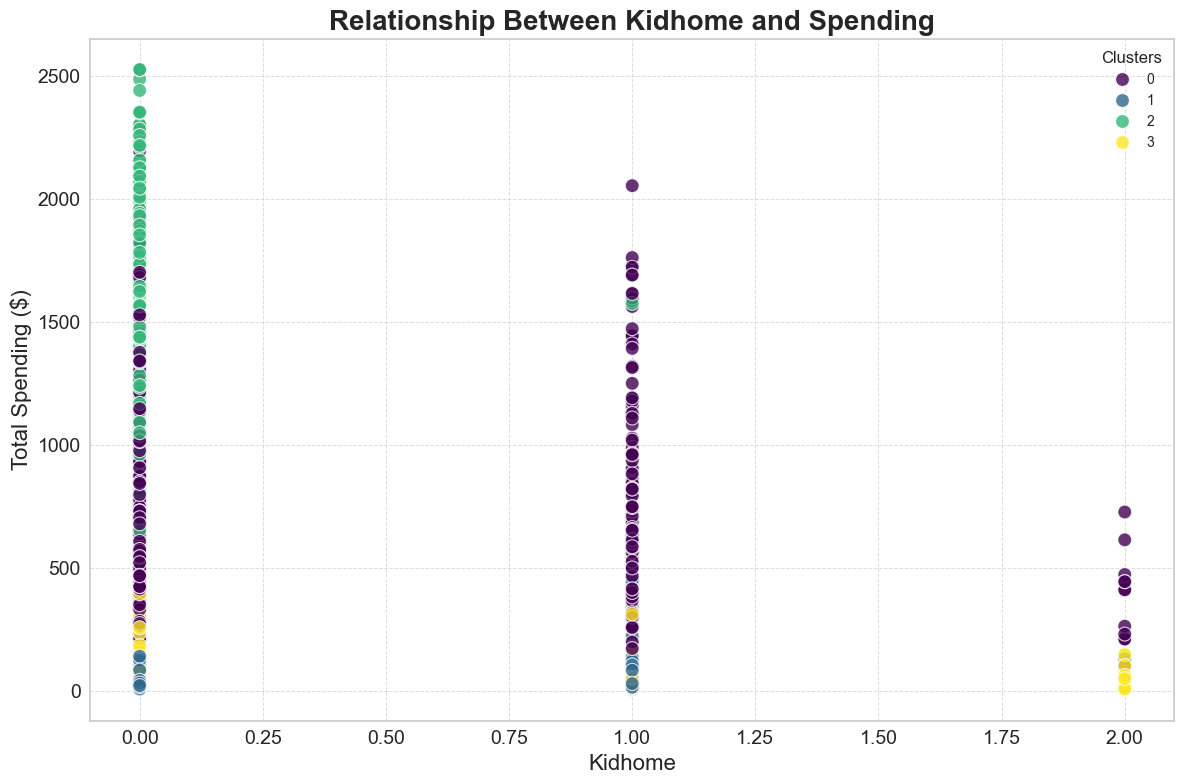

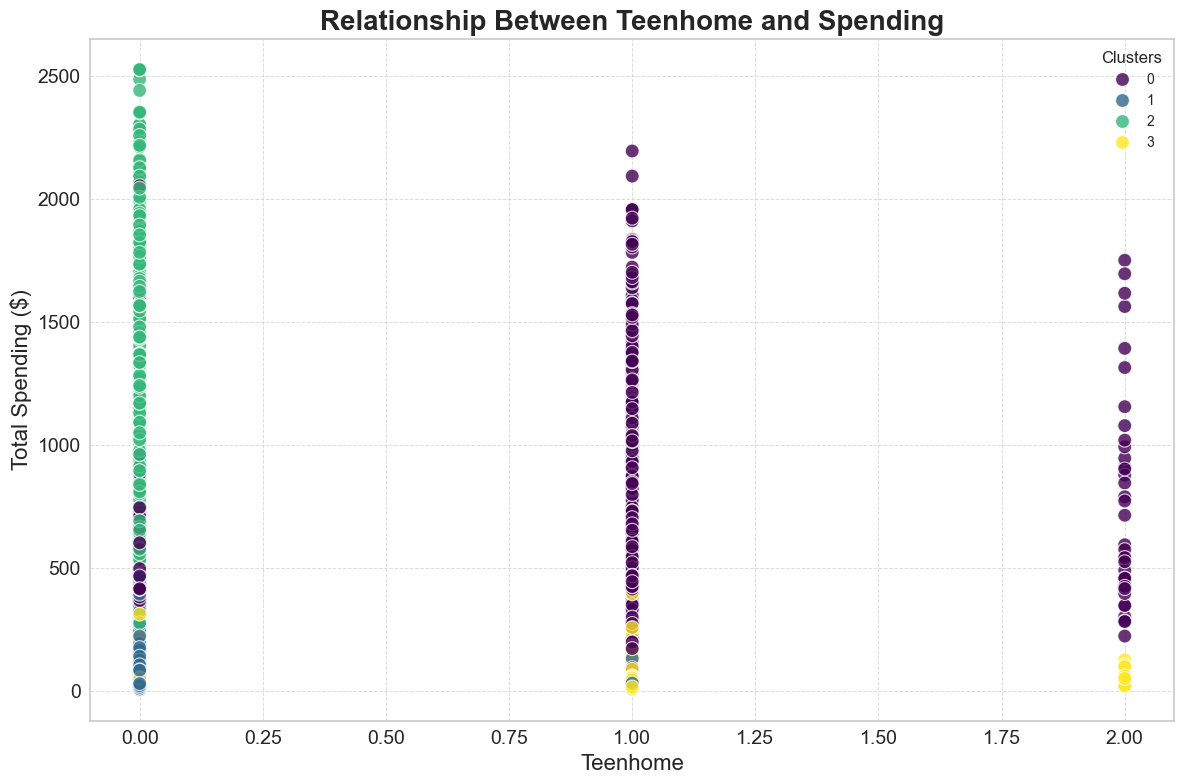

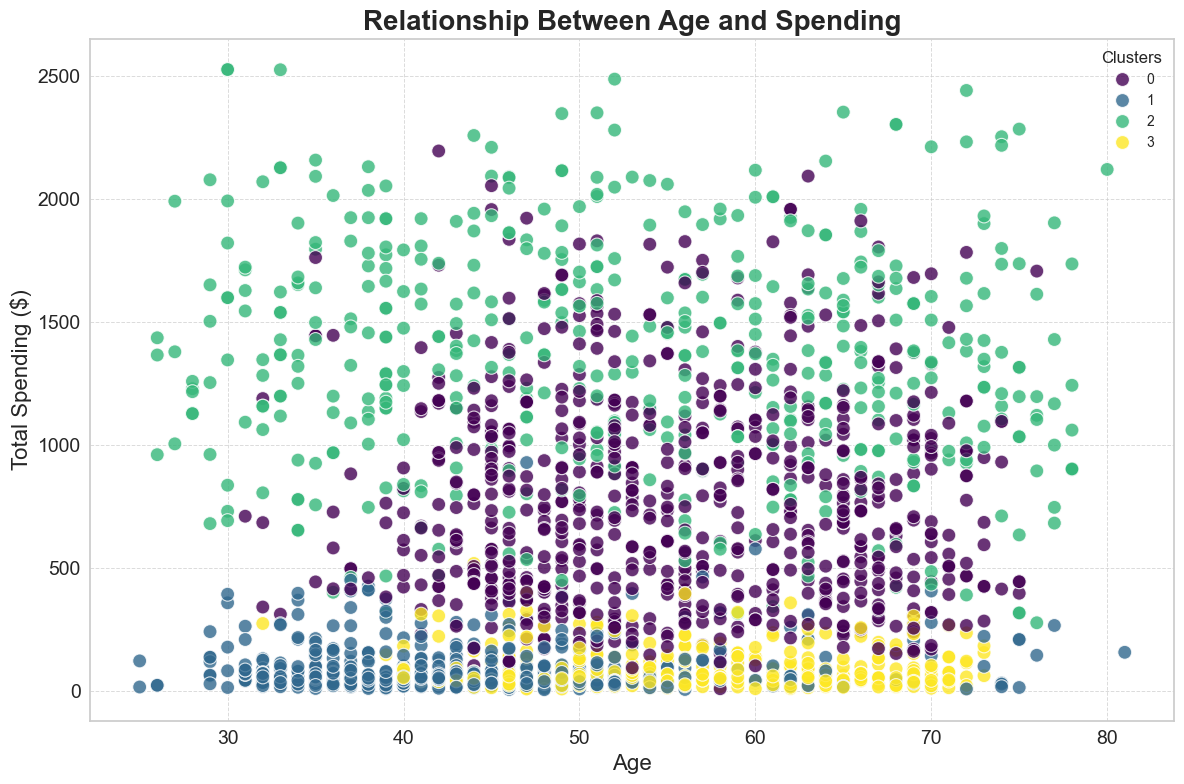

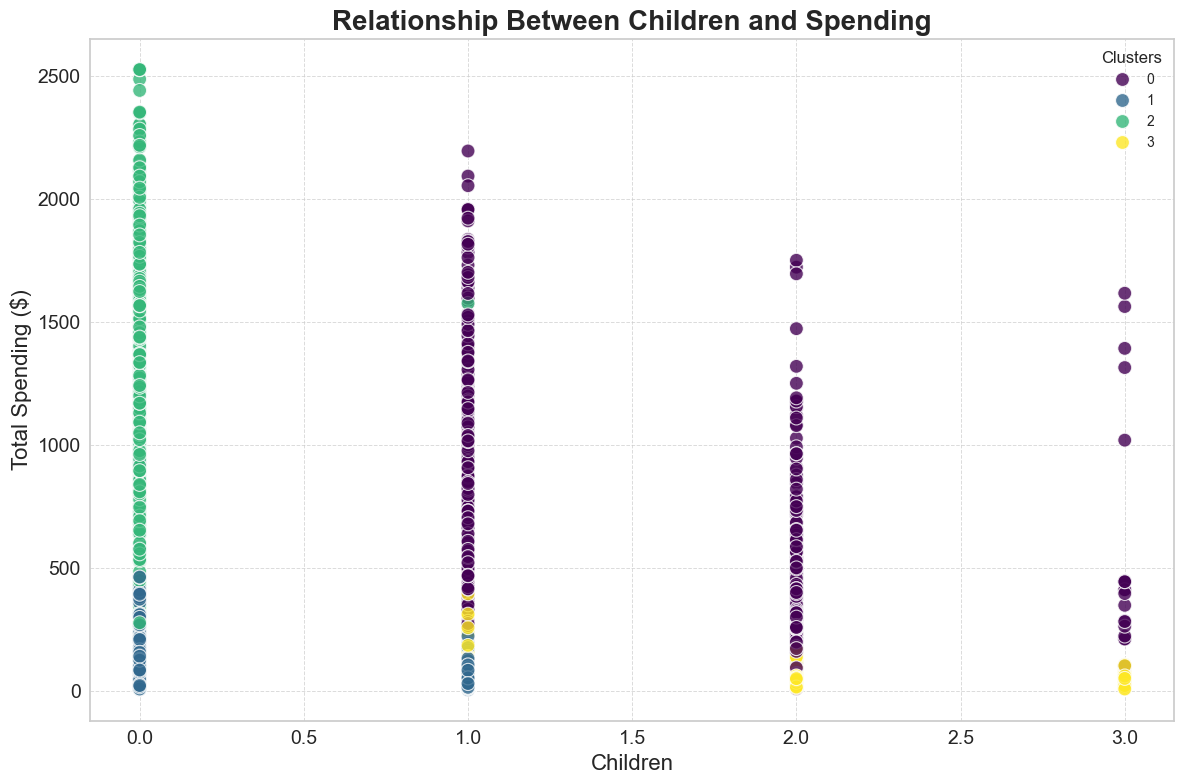

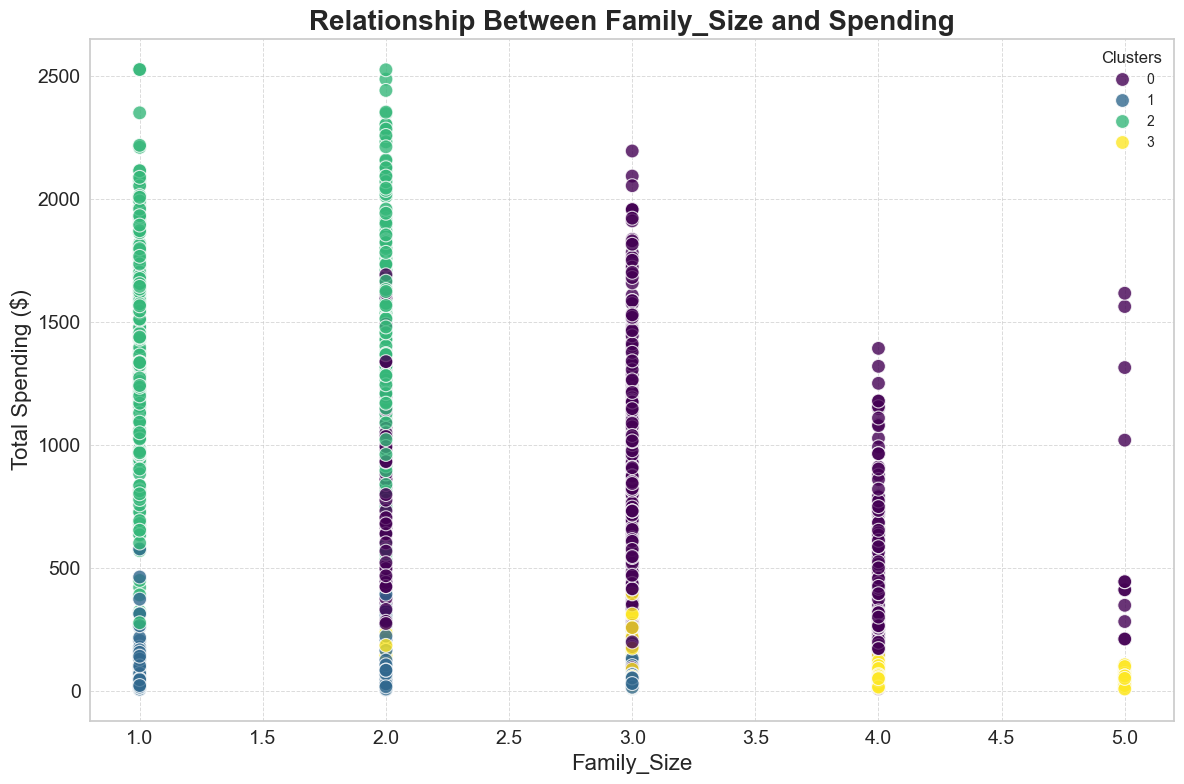

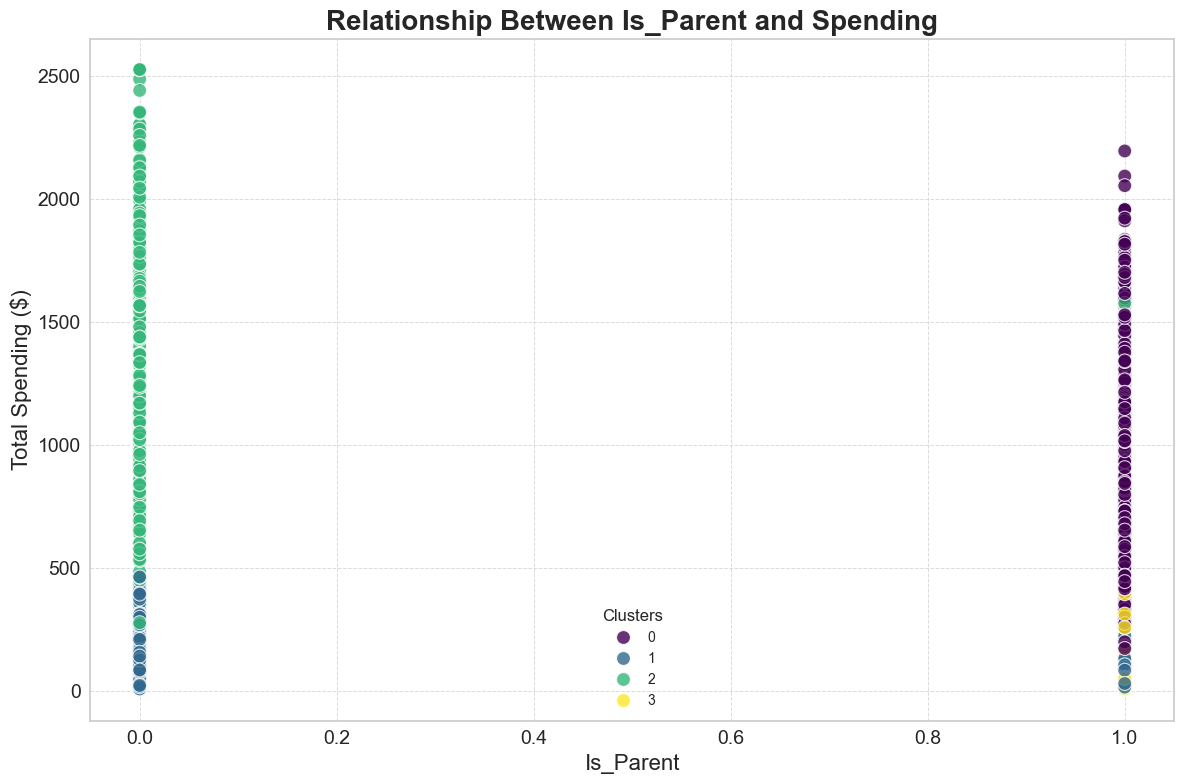

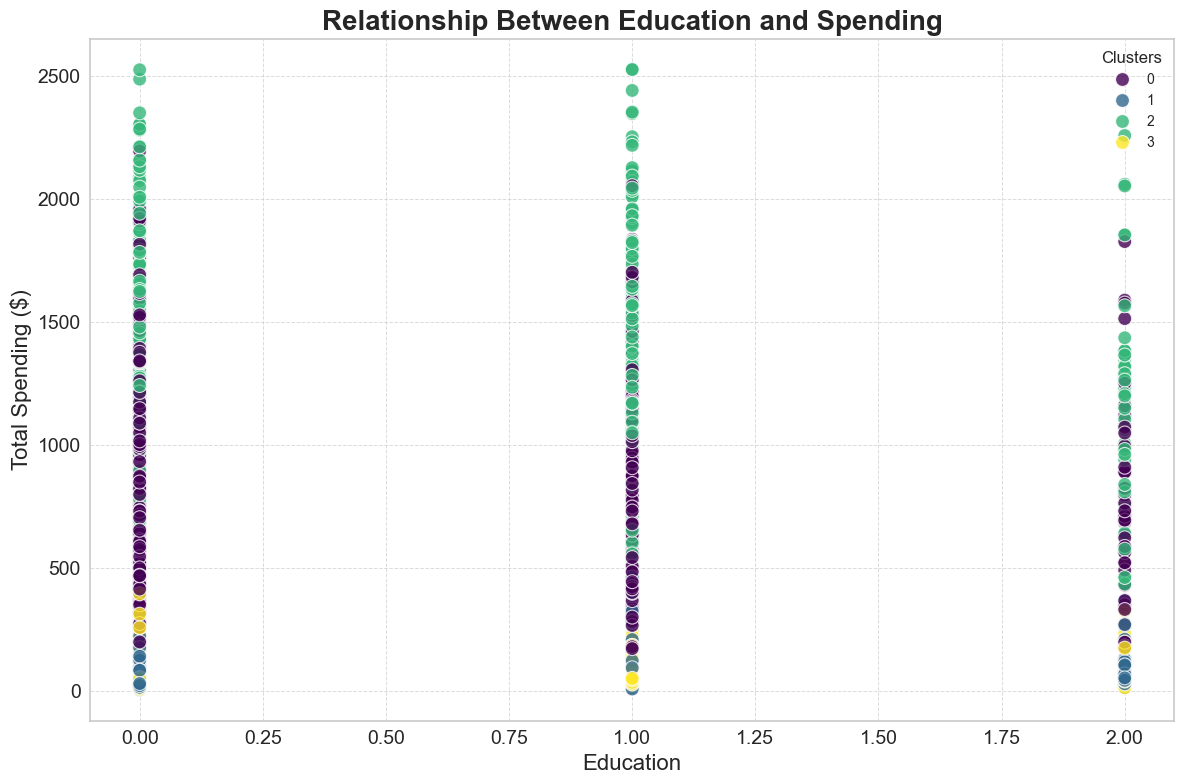

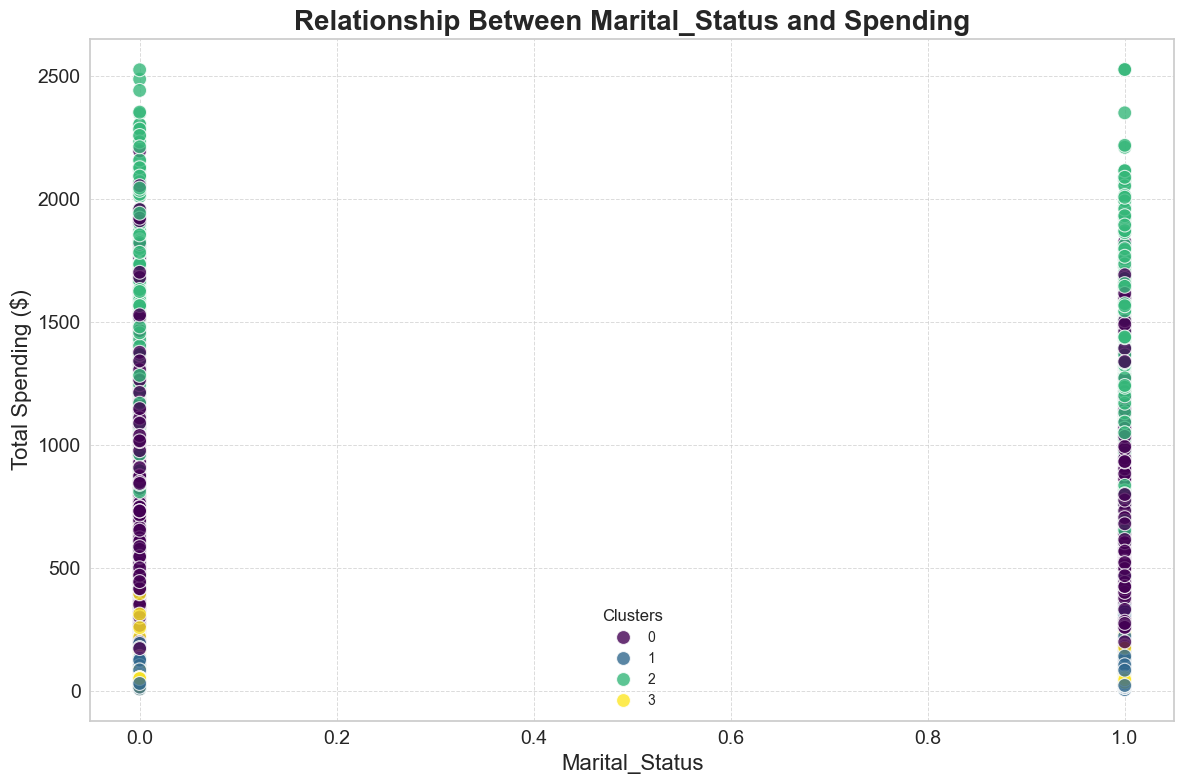

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Your existing data and palette
Personal = ["Kidhome", "Teenhome", "Age", "Children", "Family_Size", "Is_Parent", "Education", "Marital_Status"]

# Set a larger figure size for better readability
plt.figure(figsize=(15, 10))

# Loop through each variable in the Personal list
for i in Personal:
    plt.figure(figsize=(12, 8))  # Set the size for each plot
    
    # Create a scatter plot for each variable against Spending
    sns.scatterplot(
        x=data[i],
        y=data["Expenses"],
        hue=data["Clusters"],
        palette='viridis',
        alpha=0.8,          # Slightly increase opacity for better visibility
        s=100               # Increase marker size
    )
    
    # Set titles and labels for clarity
    plt.title(f'Relationship Between {i} and Spending', fontsize=20, fontweight='bold')
    plt.xlabel(i, fontsize=16)
    plt.ylabel('Total Spending ($)', fontsize=16)
    
    # Customize tick parameters for better readability
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    # Add grid lines with enhanced visibility
    plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)  # Dashed lines with slight transparency

    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()  # Display the plot



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Your existing data and palette
Personal = ["Kidhome", "Teenhome", "Age", "Children", "Family_Size", "Is_Parent", "Education", "Marital_Status"]

# Set a smaller figure size for better readability
plt.figure(figsize=(6, 6))  # Overall figure size

# Loop through each variable in the Personal list
for i in Personal:
    plt.figure(figsize=(6, 6))  # Set the size for each plot
    
    # Create a scatter plot for each variable against Spending
    sns.scatterplot(
        x=data[i],
        y=data["Expenses"],
        hue=data["Clusters"],
        palette='viridis',
        alpha=0.8,          # Slightly increase opacity for better visibility
        s=100               # Increase marker size
    )
    
    # Set titles and labels for clarity
    plt.title(f'Relationship Between {i} and Spending', fontsize=16, fontweight='bold')
    plt.xlabel(i, fontsize=14)
    plt.ylabel('Total Spending ($)', fontsize=14)

    # Set integer ticks on the x-axis
    plt.xticks(ticks=range(int(data[i].min()), int(data[i].max()) + 1), fontsize=12)

    # Customize y-axis ticks for better readability
    plt.yticks(fontsize=12)
    
    # Add grid lines with enhanced visibility
    plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)  # Dashed lines with slight transparency

    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()  # Display the plot


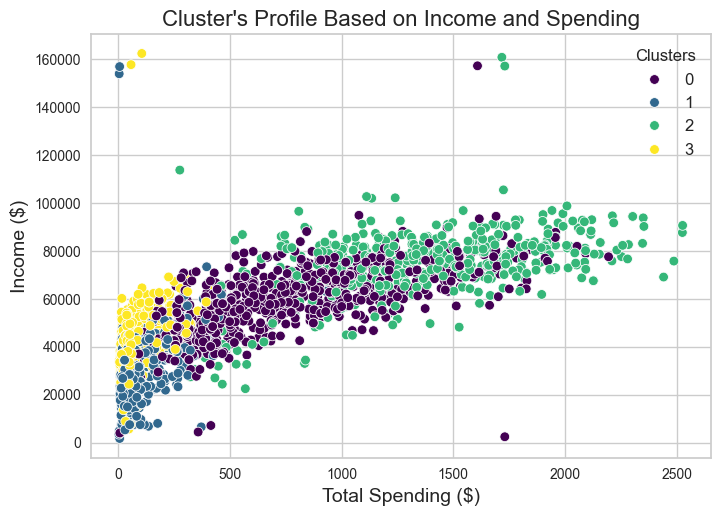

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style to 'white' to remove the grid
#sns.set_style("white")

# Create the scatter plot
pl = sns.scatterplot(data=data, x=data["Expenses"], y=data["Income"], hue=data["Clusters"], palette='viridis')
pl.set_title("Cluster's Profile Based on Income and Spending", fontsize=16)

# Customize legend
plt.legend(title='Clusters', fontsize=12)
plt.xlabel('Total Spending ($)', fontsize=14)  
plt.ylabel('Income ($)', fontsize=14)         
# Remove grid and axes spines

plt.show()  # Display the plot


<Figure size 1400x2000 with 0 Axes>

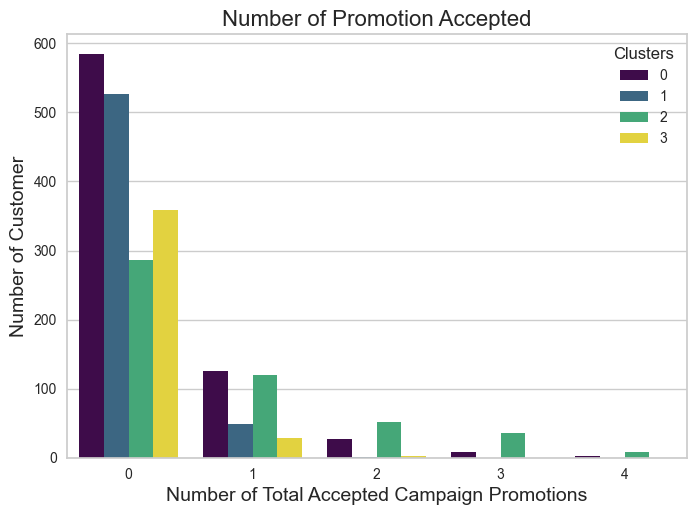

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming data is already defined and contains the necessary columns
plt.figure(figsize=(14, 20))  # Change the size as needed (width, height)

# Calculate the total number of accepted promotions
data["Total_Promos"] = data["AcceptedCmp1"] + data["AcceptedCmp2"] + data["AcceptedCmp3"] + data["AcceptedCmp4"] + data["AcceptedCmp5"]

# Plotting count of total campaign accepted
plt.figure()
pl = sns.countplot(x=data["Total_Promos"], hue=data["Clusters"], palette='viridis')
pl.set_title("Number of Promotion Accepted",fontsize=16)
pl.set_xlabel("Number of Total Accepted Campaign Promotions",fontsize=14)
pl.set_ylabel("Number of Customer",fontsize=14)  # Rename the y-axis here
plt.show()

/var/folders/76/1yzscp4d71l1rljcgf5sbbfm0000gn/T/ipykernel_37004/1880319213.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  b = sns.boxplot(
/var/folders/76/1yzscp4d71l1rljcgf5sbbfm0000gn/T/ipykernel_37004/1880319213.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  b = sns.boxplot(
/var/folders/76/1yzscp4d71l1rljcgf5sbbfm0000gn/T/ipykernel_37004/1880319213.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  b = sns.boxplot(
/var/folders/76/1yzscp4d71l1rljcgf5sbbfm0000gn/T/ipykernel_37004/1880319213.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is 

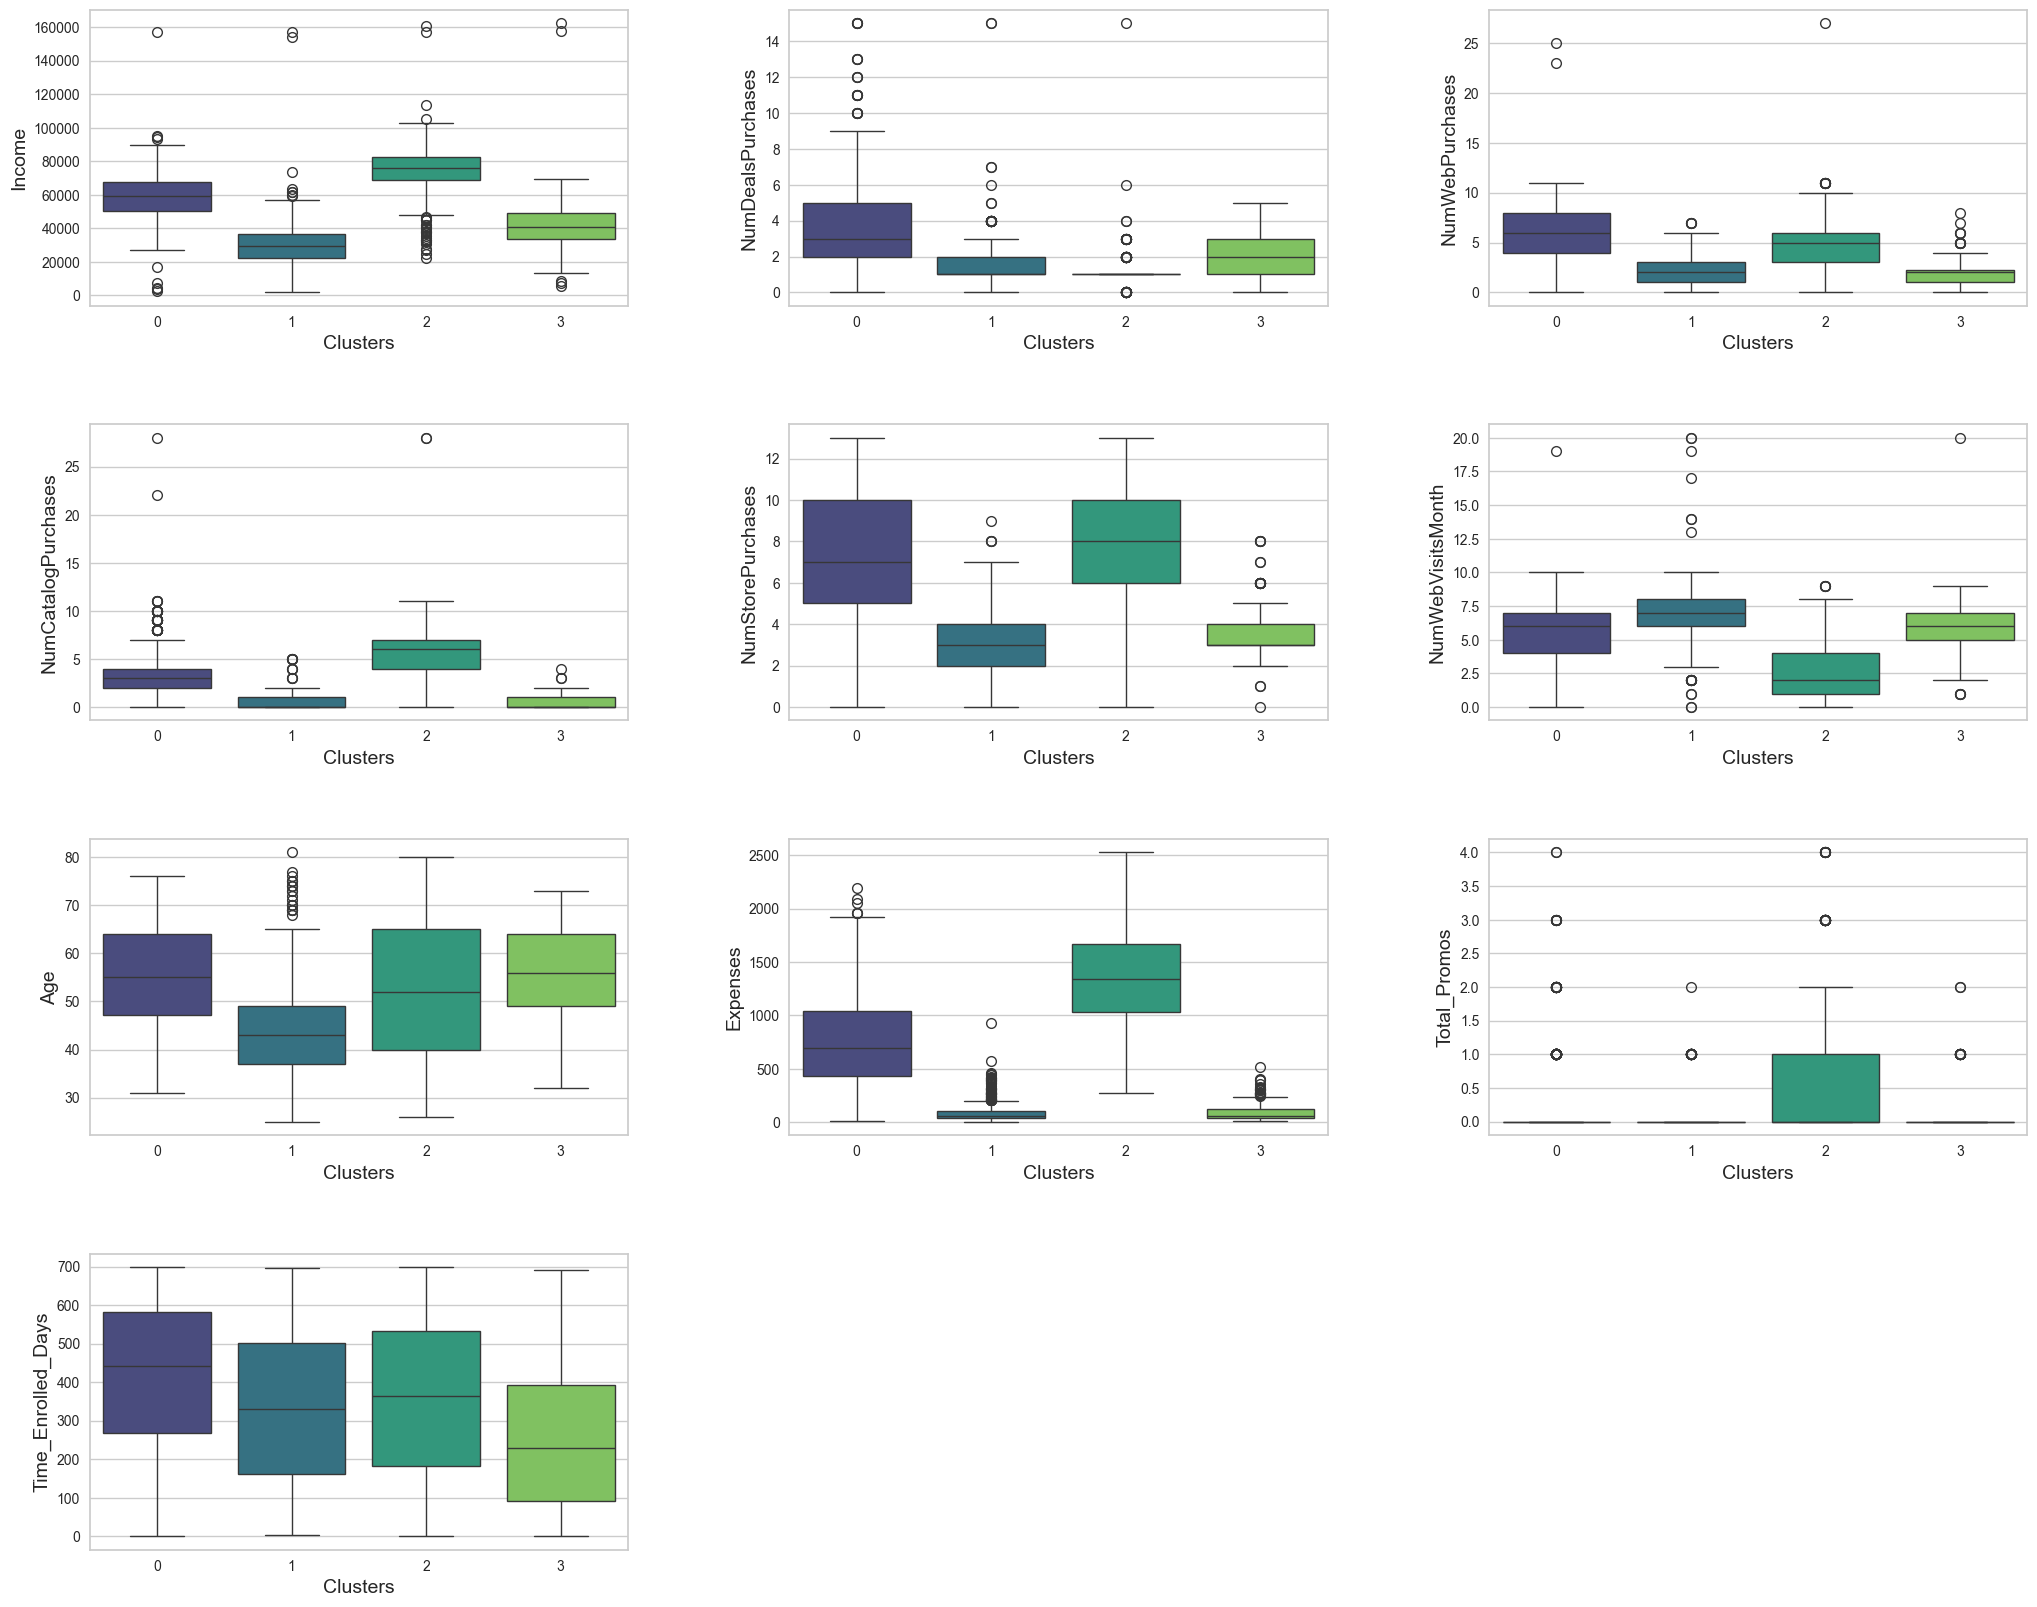

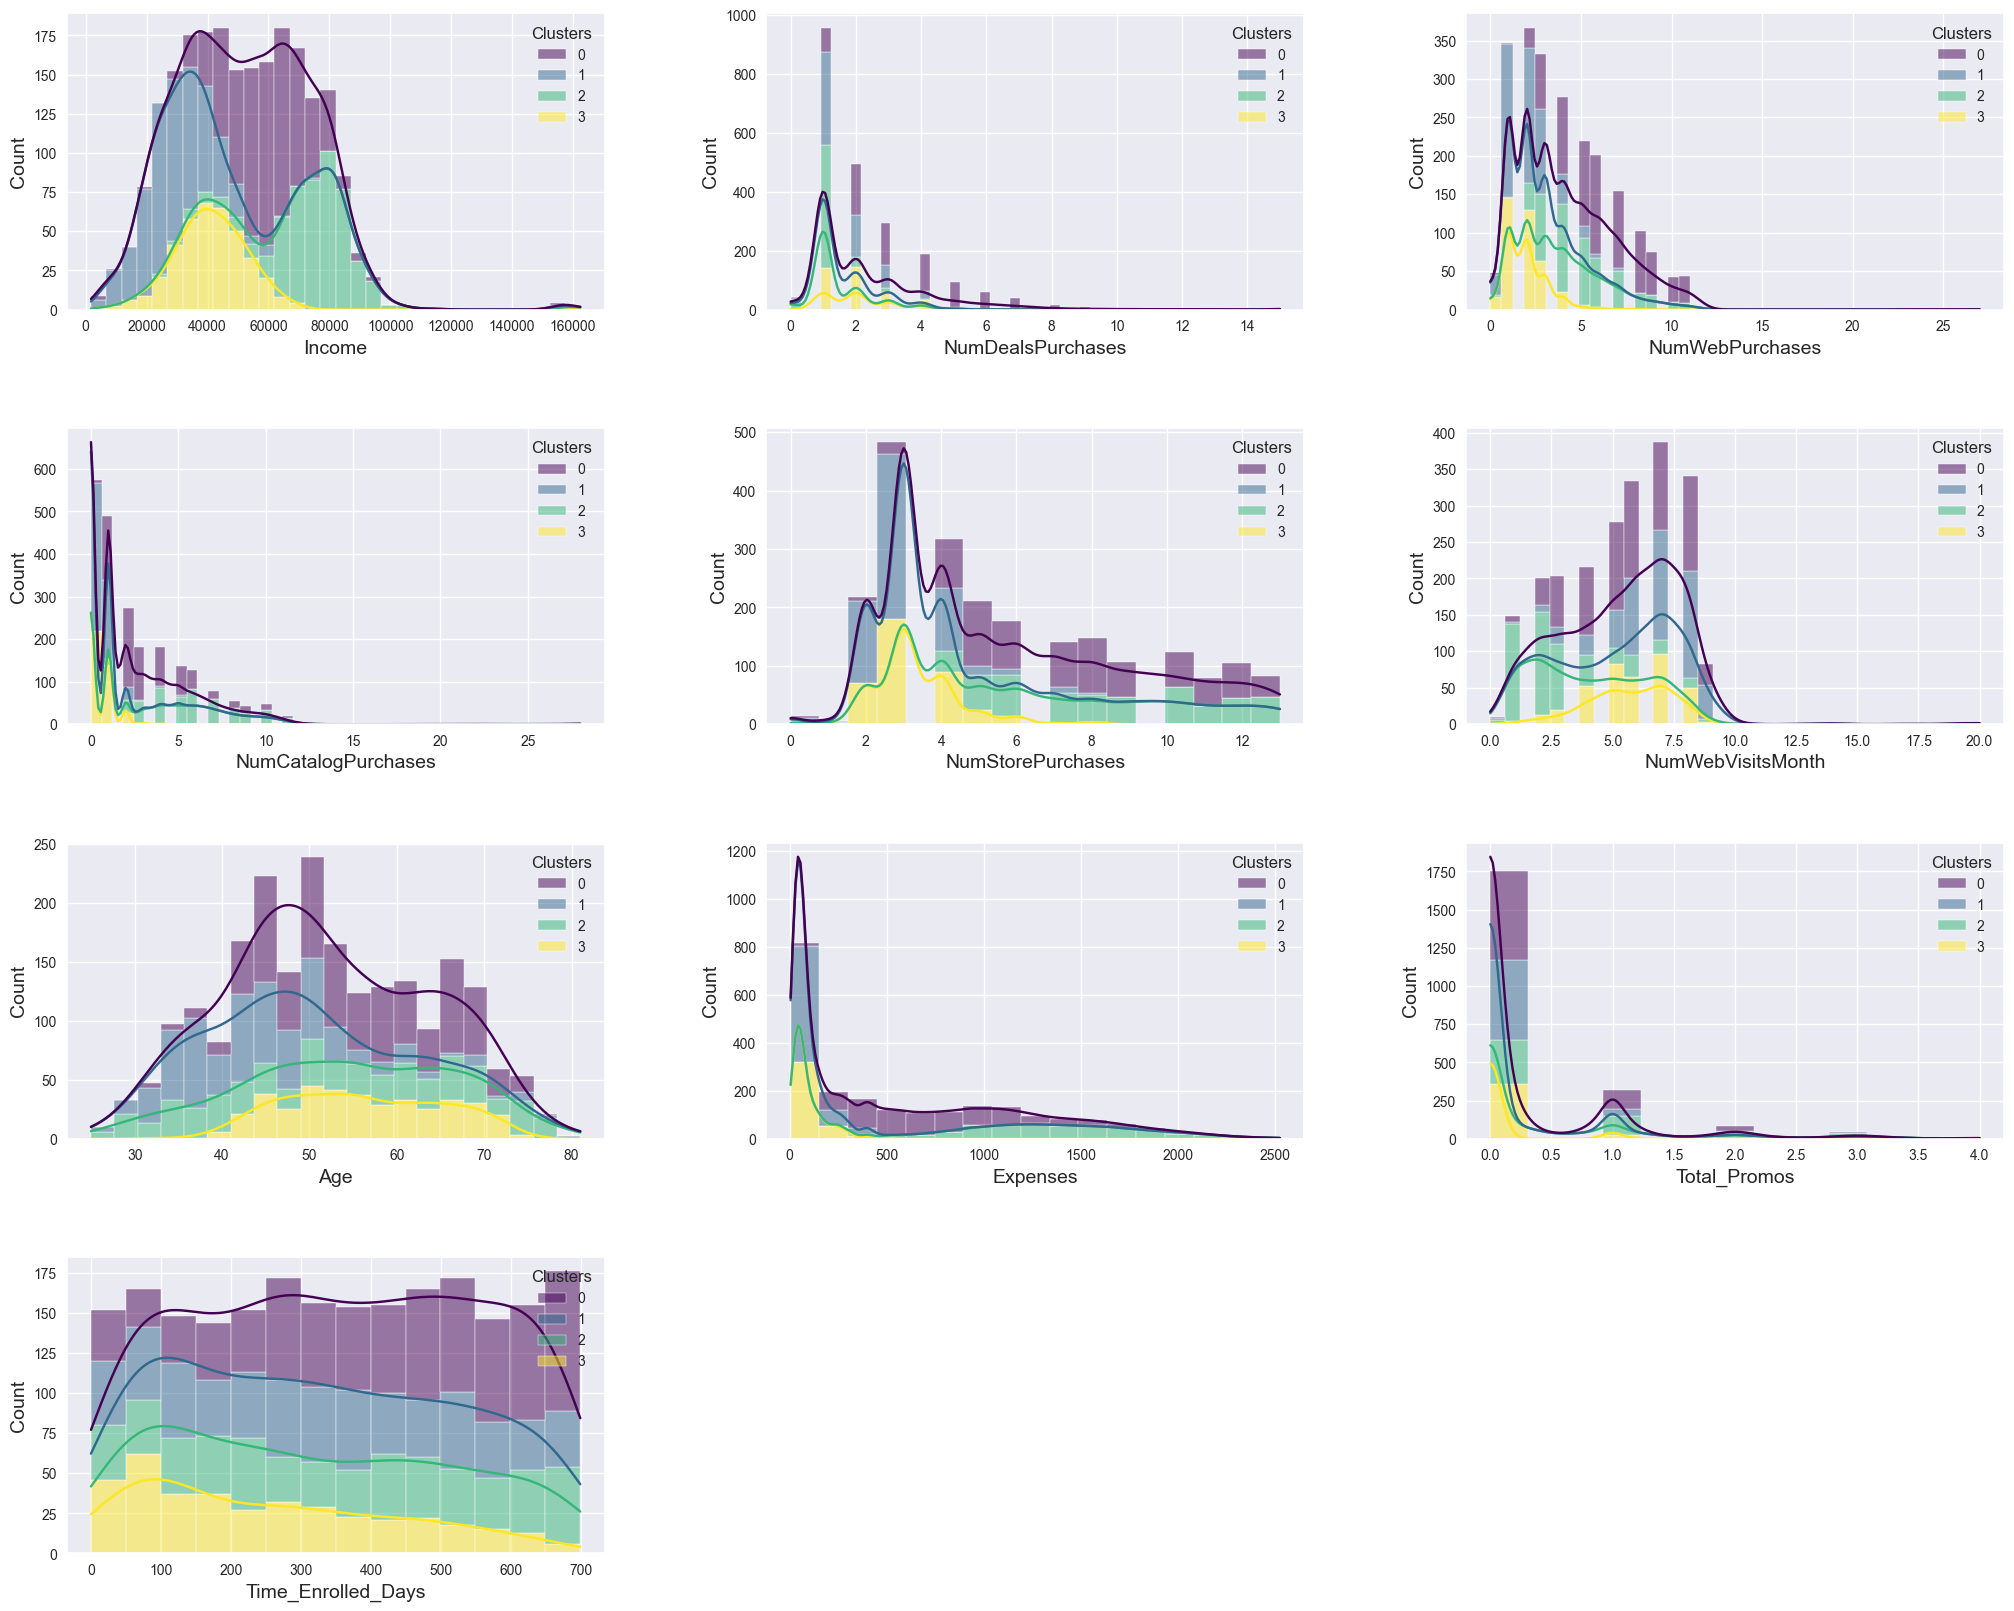

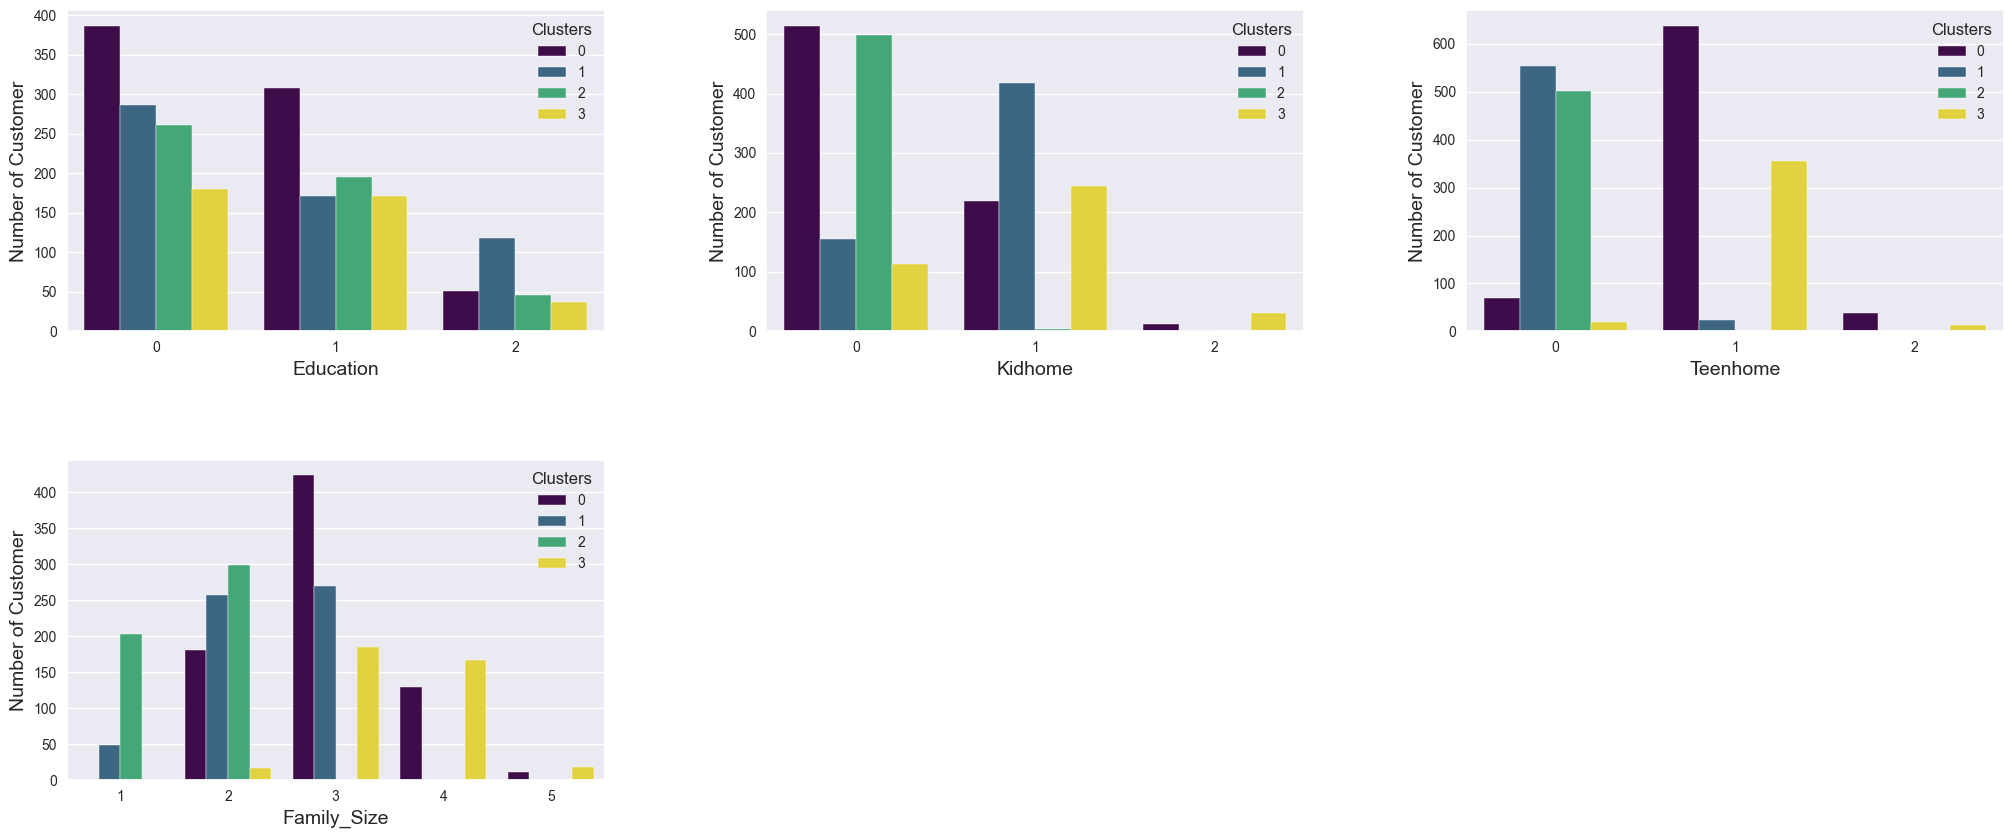

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

num_cols = ['Income', 'NumDealsPurchases', 'NumWebPurchases', 
            'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 
            'Age', 'Expenses', 'Total_Promos', 'Time_Enrolled_Days']
object_cols = ['Education', 'Kidhome', 'Teenhome', 'Family_Size']

def graph_builder(df):
    """Graphs of the main characteristics for features int | float for the best models.
    The best model was chosen based on the results of the graphs"""
    
    def boxplot():
        n_cols = len(num_cols)
        rows = (n_cols + 2) // 3  # Calculate the number of rows, rounding up
        _, axes = plt.subplots(ncols=3, nrows=rows, figsize=(25, 5 * rows))
        plt.subplots_adjust(wspace=0.3, hspace=0.4)
        axes = np.ravel(axes)  # Flatten axes array to 1D

        for num, col in enumerate(num_cols):
            if num < len(axes):  # Ensure index doesn't exceed the number of axes
                b = sns.boxplot(
                    data=df,
                    y=col,
                    x="Clusters",
                    palette="viridis",
                    ax=axes[num]
                )
                b.set_xlabel('Clusters', fontsize=14)
                b.set_ylabel(f'{df[col].name}', fontsize=14)
                sns.set_style('darkgrid')

        # Hide unused axes if there are any
        for ax in axes[len(num_cols):]:
            ax.set_visible(False)
    
    def histplot():    
        n_cols = len(num_cols)
        rows = (n_cols + 2) // 3  # Adjust row calculation
        _, axes = plt.subplots(ncols=3, nrows=rows, figsize=(25, 5 * rows))
        plt.subplots_adjust(wspace=0.3, hspace=0.4)
        axes = np.ravel(axes)  # Flatten axes array

        for num, col in enumerate(num_cols):
            if num < len(axes):
                h = sns.histplot(
                    data=df,
                    x=col,
                    hue="Clusters",
                    multiple="stack",
                    kde=True,
                    palette="viridis",
                    ax=axes[num]
                )
                h.set_xlabel(f'{df[col].name}', fontsize=14)
                h.set_ylabel('Count', fontsize=14)
                sns.set_style('darkgrid')

        # Hide unused axes
        for ax in axes[len(num_cols):]:
            ax.set_visible(False)
            
    def barplot():
        n_cols = len(object_cols)
        rows = (n_cols + 2) // 3  # Adjust row calculation
        size_cluster = df.groupby("Clusters").count().iloc[:, 0]
        _, axes = plt.subplots(ncols=3, nrows=rows, figsize=(25, 5 * rows))
        plt.subplots_adjust(wspace=0.3, hspace=0.4)
        axes = np.ravel(axes)  # Flatten axes array

        for num, col in enumerate(object_cols):
            if num < len(axes):
                data = df.groupby(["Clusters"])[col].value_counts().unstack(fill_value=0).T
                data = pd.DataFrame(data.unstack())
                data.columns = ["Number of objects"]
                data = data.reset_index()

                b = sns.barplot(
                    data=data,
                    x=col,
                    hue="Clusters",
                    y="Number of objects",
                    ax=axes[num],
                    palette="viridis"
                )
                b.set_xlabel(f'{col}', fontsize=14)
                b.set_ylabel('Number of Customer', fontsize=14)
                sns.set_style('darkgrid')

        # Hide unused axes
        for ax in axes[len(object_cols):]:
            ax.set_visible(False)
    
    boxplot()
    histplot()
    barplot()
    
# Assuming you have a DataFrame 'df' with your data
graph_builder(data)


In [39]:
import pandas as pd

# Assuming your DataFrame is called df and the cluster labels are in a column 'Cluster'
# First, filter the DataFrame for Cluster 2
cluster_2_data = data[data['Clusters'] == 2]

# Now calculate the sum of each column for Cluster 2
web_purchases_sum = cluster_2_data['NumWebPurchases'].sum()
catalog_purchases_sum = cluster_2_data['NumCatalogPurchases'].sum()
store_purchases_sum = cluster_2_data['NumStorePurchases'].sum()

# Calculate the total number of purchases in Cluster 2 (sum of all three columns)
total_purchases_cluster_2 = web_purchases_sum + catalog_purchases_sum + store_purchases_sum
# Now calculate the percentage for each purchase type
web_purchases_percent = (web_purchases_sum / total_purchases_cluster_2) * 100
catalog_purchases_percent = (catalog_purchases_sum / total_purchases_cluster_2) * 100
store_purchases_percent = (store_purchases_sum / total_purchases_cluster_2) * 100

# Display the results
print(f"Percentage of Web Purchases in Cluster 2: {web_purchases_percent:.2f}%")
print(f"Percentage of Catalog Purchases in Cluster 2: {catalog_purchases_percent:.2f}%")
print(f"Percentage of Store Purchases in Cluster 2: {store_purchases_percent:.2f}%")


Percentage of Web Purchases in Cluster 2: 26.32%
Percentage of Catalog Purchases in Cluster 2: 30.30%
Percentage of Store Purchases in Cluster 2: 43.38%


In [40]:
import pandas as pd

# Assuming your DataFrame is called df and the cluster labels are in a column 'Cluster'
# First, filter the DataFrame for Cluster 2
cluster_1_data = data[data['Clusters'] == 1]

# Now calculate the sum of each column for Cluster 2
web_purchases_sum = cluster_1_data['NumWebPurchases'].sum()
catalog_purchases_sum = cluster_1_data['NumCatalogPurchases'].sum()
store_purchases_sum = cluster_1_data['NumStorePurchases'].sum()

# Calculate the total number of purchases in Cluster 2 (sum of all three columns)
total_purchases_cluster_2 = web_purchases_sum + catalog_purchases_sum + store_purchases_sum
# Now calculate the percentage for each purchase type
web_purchases_percent = (web_purchases_sum / total_purchases_cluster_2) * 100
catalog_purchases_percent = (catalog_purchases_sum / total_purchases_cluster_2) * 100
store_purchases_percent = (store_purchases_sum / total_purchases_cluster_2) * 100

# Display the results
print(f"Percentage of Web Purchases in Cluster 1: {web_purchases_percent:.2f}%")
print(f"Percentage of Catalog Purchases in Cluster 1: {catalog_purchases_percent:.2f}%")
print(f"Percentage of Store Purchases in Cluster 1: {store_purchases_percent:.2f}%")


Percentage of Web Purchases in Cluster 1: 36.18%
Percentage of Catalog Purchases in Cluster 1: 9.07%
Percentage of Store Purchases in Cluster 1: 54.75%


In [41]:
import pandas as pd

# Assuming your DataFrame is called df and the cluster labels are in a column 'Cluster'
# First, filter the DataFrame for Cluster 2
cluster_0_data = data[data['Clusters'] == 0]

# Now calculate the sum of each column for Cluster 2
web_purchases_sum = cluster_0_data['NumWebPurchases'].sum()
catalog_purchases_sum = cluster_0_data['NumCatalogPurchases'].sum()
store_purchases_sum = cluster_0_data['NumStorePurchases'].sum()

# Calculate the total number of purchases in Cluster 2 (sum of all three columns)
total_purchases_cluster_2 = web_purchases_sum + catalog_purchases_sum + store_purchases_sum
# Now calculate the percentage for each purchase type
web_purchases_percent = (web_purchases_sum / total_purchases_cluster_2) * 100
catalog_purchases_percent = (catalog_purchases_sum / total_purchases_cluster_2) * 100
store_purchases_percent = (store_purchases_sum / total_purchases_cluster_2) * 100

# Display the results
print(f"Percentage of Web Purchases in Cluster 0: {web_purchases_percent:.2f}%")
print(f"Percentage of Catalog Purchases in Cluster 0: {catalog_purchases_percent:.2f}%")
print(f"Percentage of Store Purchases in Cluster 0: {store_purchases_percent:.2f}%")


Percentage of Web Purchases in Cluster 0: 36.14%
Percentage of Catalog Purchases in Cluster 0: 19.74%
Percentage of Store Purchases in Cluster 0: 44.12%


In [42]:
import pandas as pd

# Assuming your DataFrame is called df and the cluster labels are in a column 'Cluster'
# First, filter the DataFrame for Cluster 2
cluster_3_data = data[data['Clusters'] == 3]

# Now calculate the sum of each column for Cluster 2
web_purchases_sum = cluster_3_data['NumWebPurchases'].sum()
catalog_purchases_sum = cluster_3_data['NumCatalogPurchases'].sum()
store_purchases_sum = cluster_3_data['NumStorePurchases'].sum()

# Calculate the total number of purchases in Cluster 2 (sum of all three columns)
total_purchases_cluster_2 = web_purchases_sum + catalog_purchases_sum + store_purchases_sum
# Now calculate the percentage for each purchase type
web_purchases_percent = (web_purchases_sum / total_purchases_cluster_2) * 100
catalog_purchases_percent = (catalog_purchases_sum / total_purchases_cluster_2) * 100
store_purchases_percent = (store_purchases_sum / total_purchases_cluster_2) * 100

# Display the results
print(f"Percentage of Web Purchases in Cluster 3: {web_purchases_percent:.2f}%")
print(f"Percentage of Catalog Purchases in Cluster 3: {catalog_purchases_percent:.2f}%")
print(f"Percentage of Store Purchases in Cluster 3: {store_purchases_percent:.2f}%")


Percentage of Web Purchases in Cluster 3: 33.27%
Percentage of Catalog Purchases in Cluster 3: 9.09%
Percentage of Store Purchases in Cluster 3: 57.64%


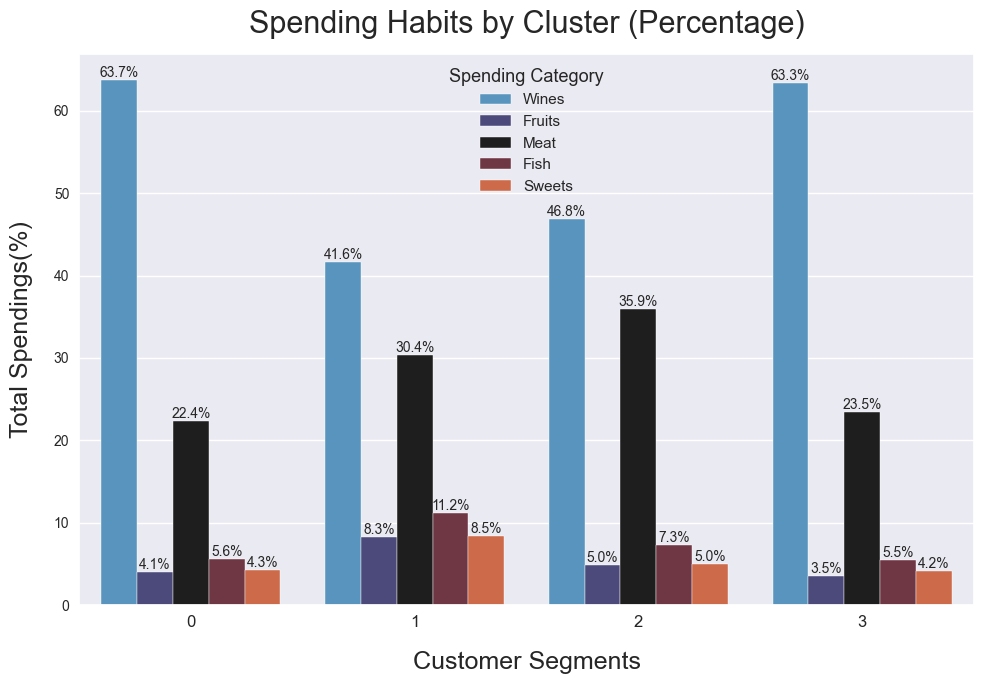

In [43]:
# Group the customer data by clusters and sum the spending amounts for each category
cluster_spendings = data.groupby('Clusters')[['Wines', 'Fruits', 
                                                  'Meat', 'Fish', 
                                                  'Sweets']].sum()

# Calculate the percentage for each spending category per cluster
cluster_spendings_percentage = cluster_spendings.div(cluster_spendings.sum(axis=1), axis=0) * 100

# Melt the DataFrame for better plotting with seaborn
cluster_spendings_melted = cluster_spendings_percentage.reset_index().melt(id_vars='Clusters', 
                                                                          var_name='Spending Category', 
                                                                          value_name='Percentage')

# Set the figure size for the plot
plt.figure(figsize=(10, 7))

# Create a stacked bar plot for spending habits by cluster in percentage
sns.barplot(x='Clusters', y='Percentage', hue='Spending Category', 
            data=cluster_spendings_melted, 
            palette='icefire')  # Use a readable palette like 'muted'

# Add data labels to each bar
for container in plt.gca().containers:
    plt.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=10)

# Setting plot title and labels
plt.title('Spending Habits by Cluster (Percentage)', fontsize=22, pad=15)
plt.xlabel('Customer Segments', fontsize=18, labelpad=15)
plt.ylabel('Total Spendings(%)', fontsize=18, labelpad=15)

# Customize legend
plt.legend(title='Spending Category', title_fontsize=13, fontsize=11)

# Formatting x-ticks
plt.xticks(rotation=0, ha='center', fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()

# Display plot
plt.show()


In [53]:
import pandas as pd

# Assuming cluster_0_data is your DataFrame for cluster 0

# Step 1: Get the counts of each customer segment
segment_counts = cluster_0_data['Customer_Segment'].value_counts()

# Step 2: Calculate percentages
segment_percentages = (segment_counts / segment_counts.sum()) * 100

# Step 3: Create a DataFrame to combine frequency and percentage
summary_table = pd.DataFrame({
    'Frequency': segment_counts,
    'Percentage': segment_percentages
})

# Optional: Sort the table by frequency or percentage
summary_table = summary_table.sort_values(by='Frequency', ascending=False)

# Print the summary table
print(summary_table)


                    Frequency  Percentage
Customer_Segment                         
Loyal Customers           282   37.801609
Other                     278   37.265416
Potential Loyalist        156   20.911528
Lost Customers             23    3.083110
Best Customers              6    0.804290
At Risk                     1    0.134048


In [54]:
import pandas as pd

# Assuming cluster_0_data is your DataFrame for cluster 0

# Step 1: Get the counts of each customer segment
segment_counts = cluster_1_data['Customer_Segment'].value_counts()

# Step 2: Calculate percentages
segment_percentages = (segment_counts / segment_counts.sum()) * 100

# Step 3: Create a DataFrame to combine frequency and percentage
summary_table = pd.DataFrame({
    'Frequency': segment_counts,
    'Percentage': segment_percentages
})

# Optional: Sort the table by frequency or percentage
summary_table = summary_table.sort_values(by='Frequency', ascending=False)

# Print the summary table
print(summary_table)


                    Frequency  Percentage
Customer_Segment                         
Lost Customers            205   35.590278
At Risk                   136   23.611111
Potential Loyalist        122   21.180556
Other                      94   16.319444
Loyal Customers            19    3.298611


In [56]:

# Assuming cluster_0_data is your DataFrame for cluster 0

# Step 1: Get the counts of each customer segment
segment_counts = cluster_2_data['Customer_Segment'].value_counts()

# Step 2: Calculate percentages
segment_percentages = (segment_counts / segment_counts.sum()) * 100

# Step 3: Create a DataFrame to combine frequency and percentage
summary_table = pd.DataFrame({
    'Frequency': segment_counts,
    'Percentage': segment_percentages
})

# Optional: Sort the table by frequency or percentage
summary_table = summary_table.sort_values(by='Frequency', ascending=False)

# Print the summary table
print(summary_table)


                    Frequency  Percentage
Customer_Segment                         
Other                     207   41.235060
Loyal Customers           181   36.055777
Potential Loyalist         95   18.924303
Best Customers             19    3.784861


In [55]:
import pandas as pd

# Assuming cluster_0_data is your DataFrame for cluster 0

# Step 1: Get the counts of each customer segment
segment_counts = cluster_3_data['Customer_Segment'].value_counts()

# Step 2: Calculate percentages
segment_percentages = (segment_counts / segment_counts.sum()) * 100

# Step 3: Create a DataFrame to combine frequency and percentage
summary_table = pd.DataFrame({
    'Frequency': segment_counts,
    'Percentage': segment_percentages
})

# Optional: Sort the table by frequency or percentage
summary_table = summary_table.sort_values(by='Frequency', ascending=False)

# Print the summary table
print(summary_table)


                    Frequency  Percentage
Customer_Segment                         
Lost Customers            137   35.309278
At Risk                    95   24.484536
Potential Loyalist         92   23.711340
Other                      50   12.886598
Loyal Customers            14    3.608247
